In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

## Terminology

- Price :  $P$
Total price of a house
- Tenure period : $T$ (years)
Amount of time to fully pay off the mortgage
- Monthly payment : $M$
- Remaining value : $R[t]$
- Interest : $I[t]$

In [2]:
def plot_payments(tenure_mths, remaining, interest):
    t = np.arange(tenure_mths) / 12
    _,ax = plt.subplots(3, figsize=(12,9), sharex=True)
    ax[0].plot(t, remaining)
    ax[0].set_ylabel("Remaining (k $)")
    
    ax[1].plot(t, np.cumsum(interest))
    ax[1].set_ylabel("Interest Paid (k $)")
    
    ax[2].plot(t, interest * 1e3)

    ax[2].set_xlabel("time (years)")
    _ = [ ax[i].grid() for i in range(3) ]

def interest_yearly_to_monthly(interest_year):
    """
    Convert a yearly interest rate to monthly
        x = (1 + interest_year) ^ {1/12} - 1
    """
    return (1 + interest_year) ** (1/12) - 1
    
def required_monthly_payment(P, T, I):
    """
    Calculate required monthly payment for a given interest rate and tenure period
    
    Parameters
    ----------
    P : Total minus downpayment and grants
    T : Tenure, Number of months to fully pay off loan
    I : Monthly interest rate
    
    Returns
    -------
    monthly : Required monthly payment
    
    Notes
    -----
    Solution is given by the recurrence relation
        0 = ... (((P - m)(1 + I) - m)(1 + I) - m) ...
    
    Which can be unrolled into
        (1+I)^T P = (1 + I)^T m + (1 + I)^{T-1} m + ... + (1 + I)^0 m
    
    """
    A = 0
    for t in range(T-1):
        A += (1 + I)**t
    m = (1 + I)**T * P / A
    return m
    
def calculate_payments(total, tenure, interest_year=0.02, downpayment_percent=0.25, grant=0):
    """
    Calculate remainining loan and interest for a given interest, tenure period,
    downpayment percentage and optional grant
    
    Parameters
    ----------
    total : Total cost
    interest_year : float (<1.0)
        Yearly interest rate (2% is 0.02)
    downpayment_period : float (<1.0)
        Percentage of total as downpayment
    grant : (optional) Amount of grant received, in addition to downpayment
    
    Returns
    -------
    remaining : ndarray
        (L,) array of the remaining loan
    interest : ndarray
        (L,) array of the interest / month
    
    """
    tenure_mths = 12 * tenure
    downpayment = total * downpayment_percent
    P = total - downpayment - grant
    interest_month = interest_yearly_to_monthly(interest_year)
    
    # Calculated required monthly payment to achieve tenure
    monthly = required_monthly_payment(P, tenure_mths, interest_month)

    t = np.arange(0, tenure_mths)
    remaining = np.zeros(tenure_mths)
    interest  = np.zeros(tenure_mths)
    remaining[0] = total - downpayment - grant

    for i in t[1:]:
        remaining[i] = remaining[i-1] - monthly
        interest[i]  = remaining[i-1] * interest_month
        remaining[i] += interest[i]
    
    # Clean up
    interest[0] = interest[1]
    remaining[remaining < 0] = np.nan
    interest[interest < 0] = np.nan
    
    return remaining, interest, tenure_mths, monthly

In [3]:
def percentile_between(x, q):
    """
    Return the q percentile of x about nominal value x0
    
    Parameters
    ----------
    x0 : ndarray
        (N,) array of Nominal values of x
    x : ndarray
        (N,K) array of Values
    q : float (0 < q < 100)
        Percentile
        
    Returns
    -------
    upper : ndarray
    lower : ndarray
    
    """
    upper = np.percentile(x, 50+q/2, axis=-1)
    lower = np.percentile(x, 50-q/2, axis=-1)
    return upper, lower

Total price: $400k, Tenure between 10 to 35 



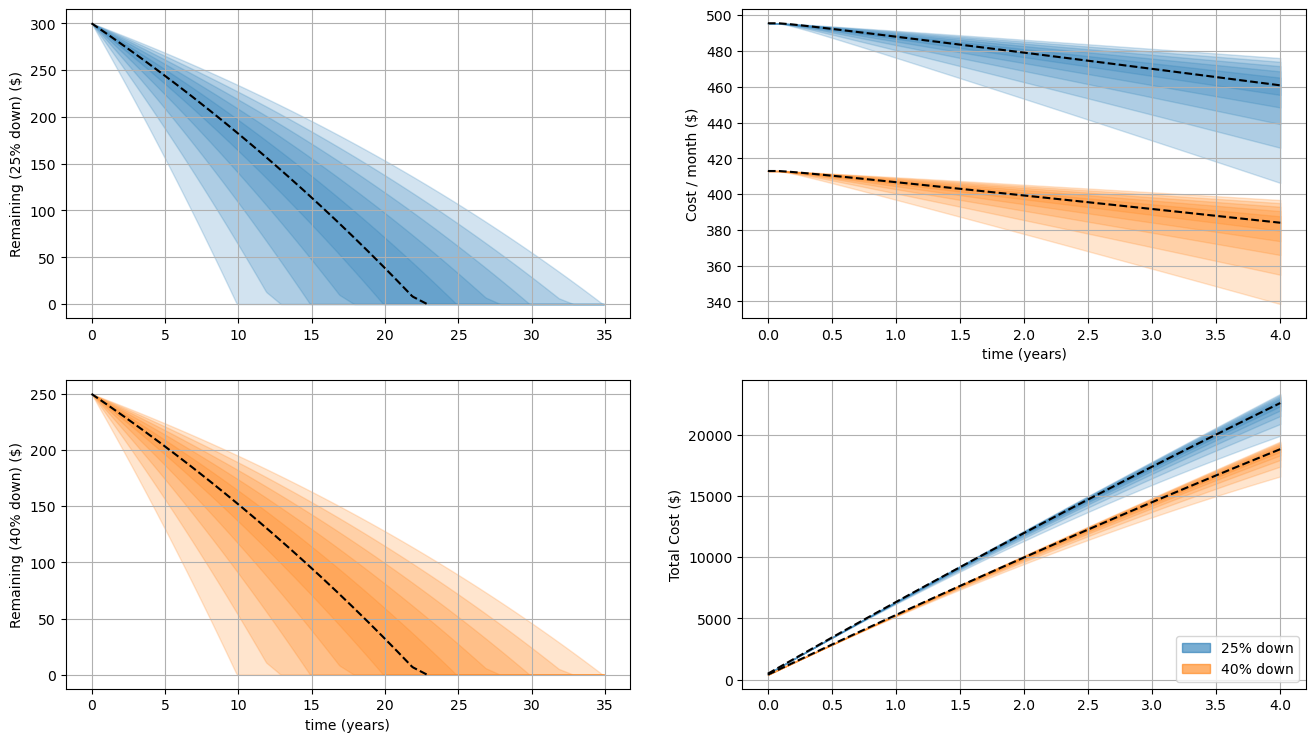

In [27]:
total          = 400
tenure_range   = range(10,36,1)
inflation_rate = interest_yearly_to_monthly(0.02)

print(f"Total price: ${total}k, Tenure between {tenure_range[0]} to {tenure_range[-1]} \n")

# =========================== Calculate Monthly and Interest ===========================
remaining = []
interest = []
interest_vs_tenure = []
interest_vs_tenure_infl = []
monthly_required = []
for i, grant in enumerate([0, 50]):
    R = np.zeros((12*35, len(tenure_range)))
    I = np.zeros((12*35, len(tenure_range)))
    IvT = []
    IvT_infl = []
    m = []
    for j,tenure in enumerate(tenure_range):
        # Calculate P,I,T and M
        sol = calculate_payments(total, interest_year=0.02, tenure=tenure, grant=grant)
        P, Ik, tenure_mths, monthly = sol
        
        t = tenure_mths/12
        R[:len(P),j] = P
        I[:len(Ik),j] = Ik
        
        total_interest = np.max(np.cumsum(Ik))
        
        I_all_infl = []
        for infl in np.arange(0,4,1):
            # Calculate interest amount relative to inflation
            inflation_rate = interest_yearly_to_monthly(infl/100)
            inflation_vector = np.power((1 + inflation_rate), np.arange(len(Ik)))    
            total_interest_infl = np.max(np.cumsum(Ik / inflation_vector))
            I_all_infl.append( np.array([t, total_interest_infl]) )
        
        # Store data
        IvT.append( np.array([t, total_interest]) )
        IvT_infl.append( np.stack(I_all_infl, axis=-1) )
        m.append( np.array([t, monthly]) )
    
    # Aggregate data
    remaining.append( R )
    interest.append( I )
    interest_vs_tenure.append( np.stack(IvT) )
    interest_vs_tenure_infl.append( np.stack(IvT_infl) )
    monthly_required.append( np.stack(m) )

# =========================== Precentile Fill for Remaining over time ===========================
_,axes = plt.subplots(2,2, figsize=(16,9), dpi=100, sharex=False)
ax = axes.T.flatten()

cmap = ['tab:blue', 'tab:orange']
remaining = np.nan_to_num(remaining)
t = np.arange(12*35)/12
for i,R in enumerate(remaining):
    for q in range(0,101,20):
        upper, lower = percentile_between(R, q)
        ax[i].fill_between(t, upper, lower, color=cmap[i], alpha=0.2) #, edgecolor=None)
        # ax[i,0].plot(t, upper, t, lower, color=cmap[i])
        if q == 0:
            ax[i].plot(t[upper > 0], upper[upper > 0], 'k--')

# =========================== Precentile Fill for Interest paid after N years ===========================
tShort = t[:1 + 12*4]
for i,I in enumerate(interest):
    for q in range(0,101,20):
        numMonths = np.arange( 1, len(I)+1, dtype=float )
        
        X = np.cumsum( I * 1000, axis=0 )
        upper, lower = percentile_between(X[:1 + 12*4], q)
        ax[3].fill_between(tShort, upper, lower, color=cmap[i], alpha=0.2)
        if q == 0: ax[3].plot(tShort[upper > 0], upper[upper > 0], 'k--')
        
        X /= numMonths.reshape((-1,1))
        upper, lower = percentile_between(X[:1 + 12*4], q)
        ax[2].fill_between(tShort, upper, lower, color=cmap[i], alpha=0.2)
        if q == 0: ax[2].plot(tShort[upper > 0], upper[upper > 0], 'k--')

# Legend
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='tab:blue', alpha=0.6, label='25% down')
orange_patch = mpatches.Patch(color='tab:orange', alpha=0.6, label='40% down')

plt.legend(handles=[blue_patch, orange_patch], loc="lower right")

# Label
ax[0].set_ylabel("Remaining (25% down) ($)")
ax[1].set_ylabel("Remaining (40% down) ($)")

ax[2].set_ylabel("Cost / month ($)")
ax[3].set_ylabel("Total Cost ($)")

ax[1].set_xlabel("time (years)")
ax[2].set_xlabel("time (years)")

_ = [ a.grid() for a in ax.flatten() ]

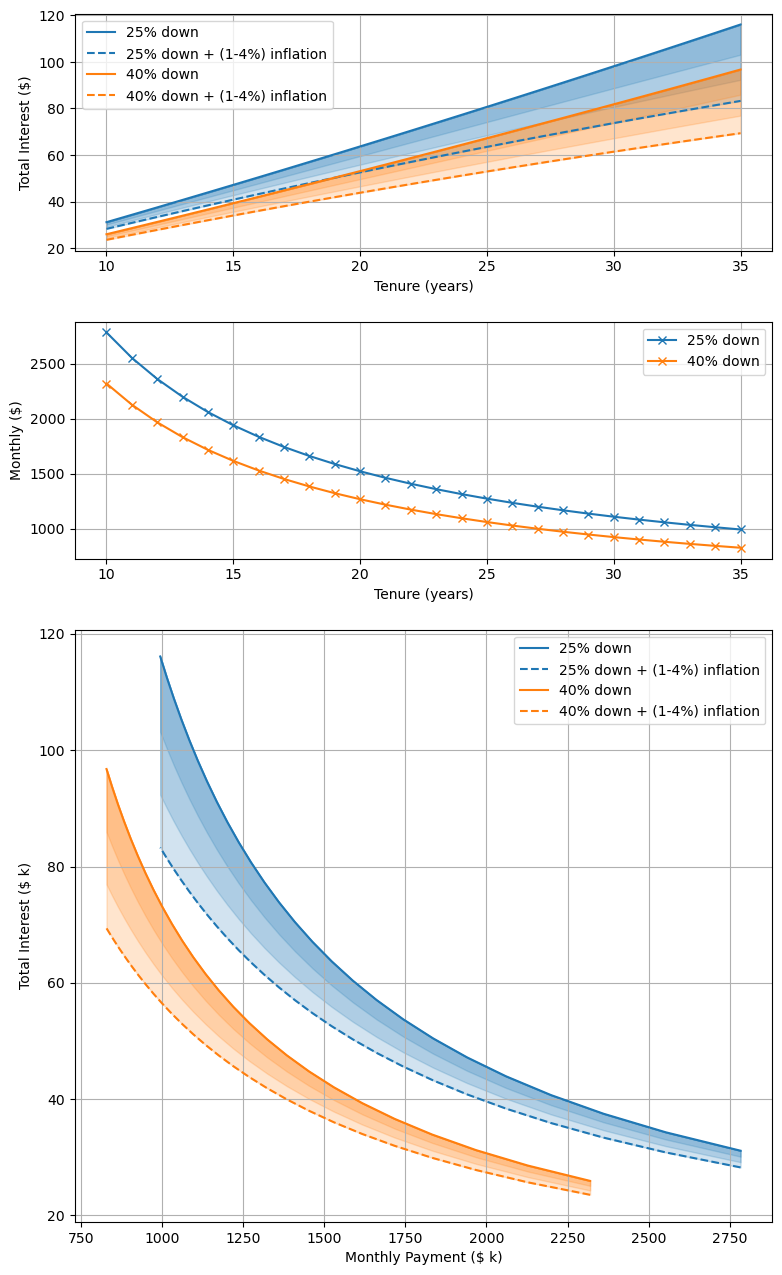

In [26]:
_, ax = plt.subplots(3, gridspec_kw={'height_ratios': [1,1,2.5]}, figsize=(9,16), dpi=100)
cmap = ['tab:blue', 'tab:orange']

# =========================== Interest vs Tenure ===========================
for i, (IvT, IvT_infl) in enumerate(zip(interest_vs_tenure, interest_vs_tenure_infl)):
    # Fill_between 0% and 4%
    ax[0].plot(IvT[:,0], IvT[:,1], color=cmap[i])
    ax[0].plot(IvT[:,0], IvT_infl[:,1,-1], '--', color=cmap[i])
    for j in range(IvT_infl.shape[2]):
        ax[0].fill_between(IvT[:,0], IvT[:,1], IvT_infl[:,1,j], color=cmap[i], alpha=0.2, label='_nolegend_')

ax[0].legend(['25% down', '25% down + (1-4%) inflation', '40% down', '40% down + (1-4%) inflation'])

ax[0].set_ylabel("Total Interest ($)")
ax[0].set_xlabel("Tenure (years)")

# =========================== Monthly vs Tenure ===========================
for m in monthly_required:
    ax[1].plot(m[:,0], m[:,1] * 1000, '-x')

ax[1].legend(['25% down', '40% down'])

ax[1].set_ylabel("Monthly ($)")
ax[1].set_xlabel("Tenure (years)")

# =========================== Monthly vs Total Interest ===========================
for i,_ in enumerate(interest_vs_tenure):
    IvT = interest_vs_tenure[i]
    IvT_infl = interest_vs_tenure_infl[i]
    m = monthly_required[i] * 1000
    
    # Fill between 0% and 4% inflation
    ax[2].plot(m[:,1], IvT[:,1], color=cmap[i])
    ax[2].plot(m[:,1], IvT_infl[:,1,-1], '--', color=cmap[i])
    for j in range(IvT_infl.shape[2]):
        ax[2].fill_between(m[:,1], IvT[:,1], IvT_infl[:,1,j], color=cmap[i], alpha=0.2, label='_nolegend_')

ax[2].legend(['25% down', '25% down + (1-4%) inflation', '40% down', '40% down + (1-4%) inflation'])

ax[2].set_ylabel("Total Interest ($ k)")
ax[2].set_xlabel("Monthly Payment ($ k)")

_ = [ a.grid() for a in ax.flatten()  ]